# First Zonal Harmonic Forecasting via LSTM

In this notebook, I attempt the most basic prediction for the first zonal harmonic of the external field in response to solar activity. The zonal harmonic, corresponding to the associated Legendre polynomial $P_1^0$, is effectively what is measured by the disturbance storm time (Dst) index, except the data that I am trying to reconstruct record only the external field response, while Dst inadvertently includes the fields generated in Earth's subsurface. 

In [2]:
# general
import numpy as np
from sklearn import preprocessing
from scipy.stats import kde
import os
import datetime as dt

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Using TensorFlow backend.


## Load Data

Let's load the data without gaps as well as the external coefficients. We'll use the unfiltered coefficients since the filtered coefficients eliminate quite a bit of small scale structure in the time series; in particular many jumps and abrupt changes in the external magnetic field are excessively smoothed and would cause the network to learn unrealistic behaviors.

In [20]:
omni_lr = pd.read_hdf('omni_hourly_1998-2017_nogaps.h5')
coeff = pd.read_hdf('external_coefficients_unfiltered.h5')

The external coefficients report hourly values centered on every half hour, starting at 0:30 on May 1, 1998 (UT). The OMNI series, however, are centered on the hour beginning at 0:00 on January 1, 1998, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). While the documentation for the OMNI data do not mention this anywhere, they also report the times with respect to universal time UT, so the time formats are the same between the datasets. 

Thus, both datasets contain data averaged within the same time bins, the bin centers are just denoted differently with the centers at the beginning of the hour for OMNI and at the middle of the hour for the external coefficient series. 

In [4]:
hrs_yr = 365*24
hrs_yr_lp = 366*24

n_yr = 20
# 2000, 2004, 2008, 2012, 2016
n_lp_yr = 5

hrs_OMNI = hrs_yr*(n_yr-n_lp_yr) + hrs_yr_lp*n_lp_yr

print('Expected number of hours in OMNI data set: %d' % hrs_OMNI)
print('Number of hours in OMNI data set: %d' % len(omni_lr))

Expected number of hours in OMNI data set: 175320
Number of hours in OMNI data set: 175320


As the above code computes, the anticipated number of hours in the OMNI data set is 175320, which is precisely what we get. 

Below, we perform a similar computation for the external coefficients going from May 1, 1998.

In [5]:
hrs_offset = (31+28+31+30)*24
hrs_ext_coeff = hrs_OMNI - hrs_offset

print('Expected number of hours in external coefficients data set: %d' % hrs_ext_coeff)
print('Number of hours in external coefficients data set: %d' % len(coeff))

Expected number of hours in external coefficients data set: 172440
Number of hours in external coefficients data set: 172439


The external coefficient series contains one less entry than I anticipate. We can plot Dst from the OMNI dataset alongside the q10 series to determine any time shift, since these time series should be very similar.

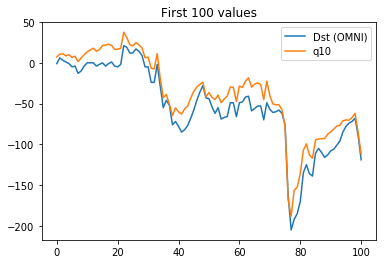

In [6]:
# first 100 data points from May 1, 1998
plt.plot(omni_lr.loc[hrs_offset:hrs_offset+100, 'Dst-index, nT'].values)
plt.plot(-coeff.loc[0:100, 'q10'].values)

plt.legend(('Dst (OMNI)', 'q10'))
plt.title('First 100 values')

plt.show()

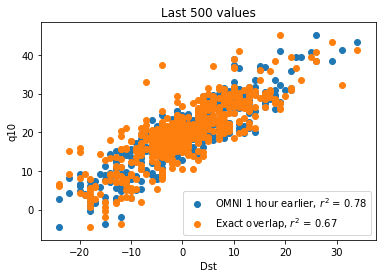

In [7]:
# last 500 data points up to 23:00 December 31, 2017
plt.scatter(omni_lr['Dst-index, nT'].tail(500).values[0:499], -coeff['q10'].tail(500).values[1:])
plt.scatter(omni_lr['Dst-index, nT'].tail(500).values[0:], -coeff['q10'].tail(500).values[0:])

r2 = []
r2.append(np.corrcoef(omni_lr['Dst-index, nT'].tail(500).values[0:499],-coeff['q10'].tail(500).values[1:])[0,1]**2)
r2.append(np.corrcoef(omni_lr['Dst-index, nT'].tail(500).values[0:],-coeff['q10'].tail(500).values[0:])[0,1]**2)

plt.xlabel('Dst')
plt.ylabel('q10')
plt.legend(('OMNI 1 hour earlier, $r^2$ = %1.2f' % r2[0], 'Exact overlap, $r^2$ = %1.2f' % r2[1]))
plt.title('Last 500 values')

plt.show()

From the above plots it is evident that the external coefficients are missing the last entry, meaning that I need to neglect the last entry of the OMNI time series corresponding to 23:00-24:00 of December 31, 2017.

Thus, taking into account all of the above, I will restrict the time series from 0:00 May 1, 1998 to 23:00 December 31, 2017.

Furthermore, we're only interested in the $q_1^0$ term, so let's neglect everything else and consider only the real part of the coefficient series.

In [21]:
omni_lr = omni_lr[hrs_offset:-1].reset_index(drop=True)
q10 = coeff['q10']
t = coeff['time'].values
t_year = 2000+t/(365.25) # federico's time axis

Finally, let's include previous values of the $q_1^0$ series in the input data, adding a column then to omni_lr (for now, ideally I woulnd't need to know previous values to make an accurate prediction). Let's also drop the Dst column (I revisit Dst prediction in the [sister notebook](forecasting_Dst_LSTM.ipynb) to this).

In [22]:
omni_lr['q10'] = q10.values
omni_lr = omni_lr.drop('Dst-index, nT', axis=1)

nfeatin = len(omni_lr.columns)

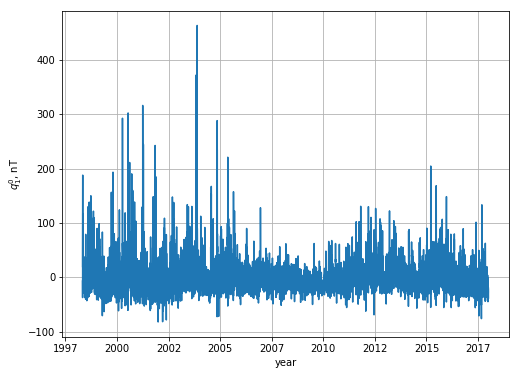

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_year, q10)
ax.set_ylabel('$q_1^0$, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## LSTM
Having imported the data, let's design, train, and test the LSTM network for this prediction problem.

### Stateless architecture

In this architecture, only batches of a given batch-size matter, with the LSTM's being trained exclusively on windows of data of size batch-size. 

In [74]:
"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
data_in: 
data_out: 
batch_size:
train_percent:
lahead:

OUT:
data_in_train:
data_out_train:
data_in_test:
data_out_test:

 """
def datasplit(data_in, data_out, batch_size, train_percent=0.8, lahead=1):
    nfeatin = data_in.shape[1]
    
    data_in = data_in[0:-lahead,:]
    data_out = data_out[lahead:,:]
    
    nbatch = int(np.floor(data_in.shape[0]/batch_size))
    
    # now construct training and testing sets
    batchrand = np.random.permutation(int(nbatch))
    trainbatch = batchrand[0:int(train_percent*nbatch)]
    testbatch = batchrand[int(train_percent*nbatch):]
    
    trainidx = np.zeros(data_in.shape[0],dtype=bool)
    for batchidx in trainbatch:
        trainidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
        
    testidx = np.zeros(data_out.shape[0],dtype=bool)
    for batchidx in testbatch:
        testidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
    
    data_in_train = data_in[trainidx,:]
    data_out_train = data_out[trainidx,:]
    data_in_test = data_in[testidx,:]
    data_out_test = data_out[testidx,:]
    return data_in_train, data_out_train, data_in_test, data_out_test



"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=200, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=False,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    rnn.add(Dropout(0.25))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop(lr=0.001)
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            verbose=1)
    hist = hist.history['loss']
    return rnn, hist

### Stateful architecture

In this architecture, we train the network on the entire series from 1998 to 2015, and then we test on 2016 and 2017. 

In [55]:
"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
data_in: 
data_out: 
batch_size:
train_percent:
lahead:

OUT:
data_in_train:
data_out_train:
data_in_test:
data_out_test:

 """
def datasplit(data_in, data_out, batch_size, train_percent=0.8, lahead=1):
    nfeatin = data_in.shape[1]
    
    data_in = data_in[0:-lahead,:]
    data_out = data_out[lahead:,:]
    
    ndat = data_in.shape[0]
    # limit for training data
    lidx = int((train_percent*ndat)-((train_percent*ndat) % batch_size))
    # limit for testing data
    ridx = int(ndat - (ndat % batch_size))
    
    trainidx = np.zeros(ndat,dtype=bool)
    trainidx[0:lidx] = True
    testidx = np.zeros(ndat,dtype=bool)
    testidx[lidx:ridx] = True
    
    data_in_train = data_in[trainidx,:]
    data_out_train = data_out[trainidx,:]
    data_in_test = data_in[testidx,:]
    data_out_test = data_out[testidx,:]
    return data_in_train, data_out_train, data_in_test, data_out_test



"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=300, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=True,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop(lr=0.002)
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = np.zeros(epochs)
    for ii in range(epochs):
        rnn.reset_states()
        tmp = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=1,
            batch_size=batch_size,
            shuffle=False,
            verbose=0)
        hist[ii] = tmp.history['loss'][0]
        print('Epoch %d, MSE %1.2e' % (ii, hist[ii]))
    return rnn, hist

### Common Functions

In [67]:
"""
Given a trained network, evaluated it on testing data and plot the
scatter plots.

IN:
dat_in_test (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_test (np.ndarray): data outputs with shape (ndata, nfeat_out)
rnn (keras.Sequential): trained network
batch_size (int/double):
feature_names (list): list of names of output features, length nfeat_out

OUT:
produces plot

"""
def test_network(dat_in_test, dat_out_test, rnn, batch_size, feature_names):
    assert len(dat_in_test.shape) == 3, 'check shape of dat_in_test'
    assert len(dat_out_test.shape) == 2, 'check shape of dat_out_test'
    nfeat_out = dat_out_test.shape[1]
    rnn.reset_states()
    dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)
    plt.figure()
    curtest = np.concatenate((scaler_output.inverse_transform(dat_out_test),\
                              scaler_output.inverse_transform(dat_pred)), axis=1)
    r2 = np.corrcoef(curtest[:,0],curtest[:,1])[0,1]**2
    plt.scatter(curtest[:,0],curtest[:,1],marker='.')
    k = kde.gaussian_kde(curtest.T)
    x, y = curtest.T
    nbins = 50
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))                                      
    plt.contour(xi,yi,zi.reshape(xi.shape), 10)
    abline(1,0)
    plt.title('%s, $r^2$ = %1.2f' % (feature_names, r2))
    plt.show()
    return dat_pred

"""
Plot straight line in current axis.
"""
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'k--')

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [75]:
batch_size = 100
lahead = 6
train_percent = 0.8

In [76]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni_lr.values, q10.values.reshape(-1,1), batch_size, train_percent, lahead)

# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1,1,nfeatin)
data_in_test = data_in_test.reshape(-1,1,nfeatin)

Epoch 1/100
137900/137900 [==============================] - 6s 46us/step - loss: 8.4804e-04
Epoch 2/100
137900/137900 [==============================] - 5s 39us/step - loss: 5.4627e-04
Epoch 3/100
137900/137900 [==============================] - 5s 38us/step - loss: 4.5742e-04
Epoch 4/100
137900/137900 [==============================] - 5s 38us/step - loss: 4.2472e-04
Epoch 5/100
137900/137900 [==============================] - 5s 39us/step - loss: 4.1366e-04
Epoch 6/100
137900/137900 [==============================] - 5s 38us/step - loss: 4.0819e-04
Epoch 7/100
137900/137900 [==============================] - 5s 39us/step - loss: 4.0212e-04
Epoch 8/100
137900/137900 [==============================] - 5s 39us/step - loss: 3.9922e-04
Epoch 9/100
137900/137900 [==============================] - 5s 39us/step - loss: 3.9659e-04
Epoch 10/100
137900/137900 [==============================] - 5s 39us/step - loss: 3.9251e-04
Epoch 11/100
137900/137900 [==============================] - 5s 39us

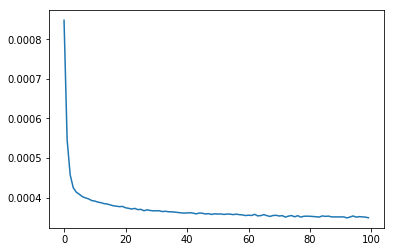

In [77]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=100)
plt.plot(hist)

### Test

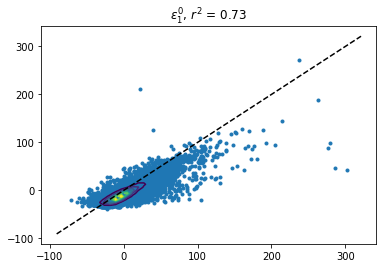

In [78]:
data_out_pred = test_network(data_in_test, data_out_test, rnn, batch_size,'$\epsilon_1^0$')